# Focal Mechanisms and Moment Tensors

Focal mechanisms describe slip on a fault arising from a purely double couple source. See Stein and Wysession's Section 4.4 for a
discussion of force couples and single forces.Focal mechanisms inherently have ambiguity over which of the two resolved planes
is the actual fault plane, and in general additional evidence is required to determine which plane if the fault plane. Focal
mechanisms are commonly used to describe the faulting styles in a region, and to invert for principle stress axis orientations.
Understanding stress orientations (and magnitude, which cannot be derived from focal mechanism inversion) is becoming useful
for understanding the likelihood of induced earthquakes (e.g.: 
[Lund Snee and Zoback 2018](https://pubs.geoscienceworld.org/tle/article/37/2/127/527282/state-of-stress-in-the-permian-basin-texas-and-new))
and for understanding how stresses change around slow-slip events (e.g. [Warren-Smith et al., 2019]()) amongst other applications.

## First motions

The simplest and most widely used method for estimating focal mechanisms is to evaluate first-motion polarities of P-waves.
The `seismic_picker.py` applet has been extended to allow you to pick polarities. Note that this needs to be the first motion
polarity, not the polarity of the maximum peak. The wavetrain of an individual seismic phase is a superposition of different
ray-paths, which may be of opposite polarities.  Polarities are either compressional (up) or dilatational (down). Waves that
show compressive first motions arise when the faults first motion is towards the seismometer (along the ray-path, which may
take an *interesting* path to the seismometer). Dilatational waves arise when the faults first motion is away from the seismometer.

<img alt="Stein and Wysession Fig 4.2-4" align="centre" style="width:40%" src="http://levee.wustl.edu/seismology/book/chapter4/chap4_sr/4_2_04_s.jpg">

Once polarities are measured they can be plotted on a stereonet to obtain a scatter of points on the focal sphere. These points can
be inverted to obtain a best fitting focal mechanism. Some important things to note are:
1. First motion amplitudes tend to zero towards the nodal planes: polarities may be obscured close to nodal planes;
2. Polarities are plotted based on take-off angle and azimuth. Both properties require accurate hypocentre locations and
   accurate ray-tracing;
3. Lower-hemisphere stereonets are commonly used because take-off angles for first arriving rays are often downwards (towards
   a faster medium).
   
To make the stereonet plots below you will need to install mplstereonet:
```bash
pip install mplstereonet
```

Event has 204 picks
Make your picks using:
	left mouse button: P
	right mouse button: S
	'a': amplitude at mouse location
	'e': end duration at mouse location - needs a P-pick to calculate duration
	P-wave polarity can be picked using the up and down arrows while hovering over a P-pick.

Picks can be deleted by hovering over them and pressing the middle mouse button


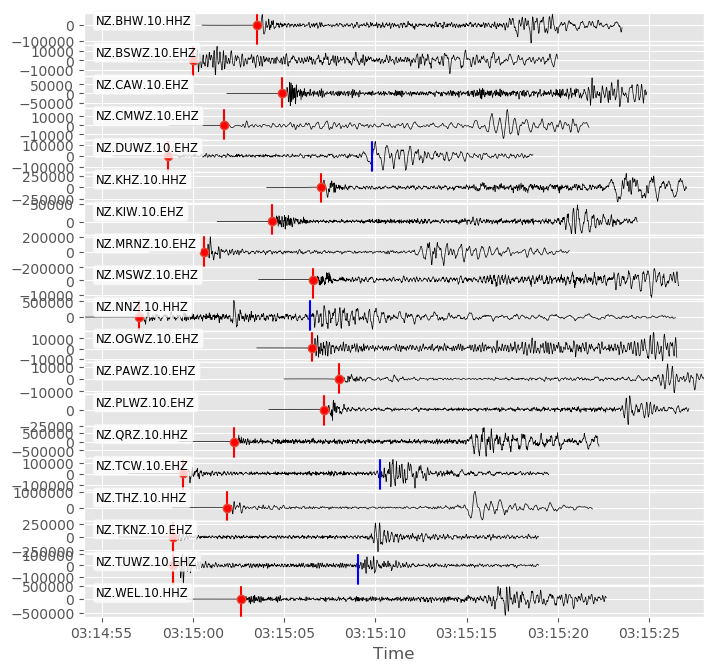

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from seismic_picker import seismic_picker 
# note that you need to be in the directory that seismic_picker.py is located
from obspy.clients.fdsn import Client

from obspy import Stream
from obspy.core.event import ResourceIdentifier
from obspy.clients.fdsn import Client

event_id = "2018p546311"

client = Client("GEONET")
cat = client.get_events(eventid=event_id)
event = cat[0]
print("Event has {0} picks".format(len(event.picks)))
# We will remove the picks from strong motion sites, they often have poor timing
event.picks = [p for p in event.picks 
               if p.waveform_id.channel_code[0] != "B"]

# Lets just look at the first 20
picks = sorted(event.picks, key=lambda p: p.time)[0:20]

st = Stream()
for pick in picks:
    tr = client.get_waveforms(
        network=pick.waveform_id.network_code,
        station=pick.waveform_id.station_code,
        location=pick.waveform_id.location_code,
        channel=pick.waveform_id.channel_code[0:-1] + "?",
        starttime=pick.time - 3, 
        endtime=pick.time + 20)
    tr.trim(pick.time - 3, pick.time +20)
    st += tr
st.merge().sort(["starttime"])

# We want to remove the arrival info because we are changing the picks
for origin in event.origins:
    origin.arrivals = []

# We will add polarities to this GeoNet event.
picked_event = seismic_picker(st.select(component="Z"), event_in=event)

# I wrote my picks out to "polarity_picked.xml": 
# picked_event.write("polarity_picked.xml", format="QUAKEML")

We now need to locate the event with the new picks - this will calculate take-off angles and azimuths that
we can use for focal mechanism calcualtion.  Note that `event.origins[n].arrivals` contains this information,
and we could have used the GeoNet derived information, but we have changed the picks so the arrivals no longer
match the picks. Thus we have to locate again. We will also calculate the focal mechanism at the same time, using
the HASH software.

Note that to use this you will need to copy the `gphs445_hash.for` file to your seisan/PRO directory and rename is
as hash_seisan.for. You will then need to run `make all` from the seisan/PRO directory again. I have editted the
source code so that the program will accept command line arguments.

In [11]:
from obspy import read_events
from obspy.clients.fdsn import Client
from geiger_inversion import seisan_hash

client = Client("GEONET")

event = read_events("polarity_picked.xml")[0]
bulk = [
    (pick.waveform_id.network_code, pick.waveform_id.station_code,
     pick.waveform_id.location_code, pick.waveform_id.channel_code, 
     pick.time - 300, pick.time + 300) for pick in event.picks]
inventory = client.get_stations_bulk(bulk, level="channel")
velocities = [
    {"velocity": 6.2, "top": 0.0},
    {"velocity": 6.6, "top": 12.0},
    {"velocity": 7.1, "top": 23.0},
    {"velocity": 8.05, "top": 31.0, "moho": True},
    {"velocity": 8.25, "top": 50.0},
    {"velocity": 8.5, "top": 80.0}]

event_located = seisan_hash(event, inventory, velocities, vpvs=1.74)
event_located.preferred_origin_id = event_located.origins[-1].resource_id

We can now try and plot this. Note that this is a deep event, so take-off angles are large (remember
that they are measured from radial towards the centre of the Earth).

In [59]:
def plot_polarities(event):
    import warnings
    import mplstereonet
    from obspy.imaging.beachball import aux_plane

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='stereonet')
    
    up_toa, up_baz, down_toa, down_baz = ([], [], [], [])

    for pick in event.picks:
        try:
            polarity = pick.polarity
        except AttributeError:
            continue
        if polarity == "undecidable":
            continue
        origin = event.preferred_origin() or event.origins[-1]
        # We want the take-off angle and azimuth
        toa, baz = (None, None)
        for arrival in origin.arrivals:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                _pick = arrival.pick_id.get_referred_object()
            if _pick is not None and _pick == pick:
                toa = arrival.takeoff_angle
                baz = arrival.azimuth
        if not (toa and baz):
            continue
        if 0. <= toa < 90.:
            toa = 90. - toa  # complement for downward angles
        elif 90. <= toa <= 180.:
            toa = 270. - toa  # project upward angles
        baz -= 90 # Calculate strike azi from direct (dip-pointing) azi
        if polarity == "positive":
            up_toa.append(toa)
            up_baz.append(baz)
        elif polarity == "negative":
            down_toa.append(toa)
            down_baz.append(baz)
    ax.rake(up_baz, up_toa, 90, "ro", label="Compressional")
    ax.rake(down_baz, down_toa, 90, "bo", label="Dilatational")
    for fm in event.focal_mechanisms:
        if fm.nodal_planes:
            if fm.nodal_planes.nodal_plane_1:
                _np = fm.nodal_planes.nodal_plane_1
                ax.plane(_np.strike, _np.dip, "k")
            if fm.nodal_planes.nodal_plane_2:
                _np = fm.nodal_planes.nodal_plane_2
                ax.plane(_np.strike, _np.dip, "k")
            elif fm.nodal_planes.nodal_plane_1:
                # Calculate the aux plane
                _np = fm.nodal_planes.nodal_plane_1
                _str, _dip, _rake = aux_plane(_np.strike, _np.dip, _np.rake)
                ax.plane(_str, _dip, "k")
    ax.legend()
    return fig

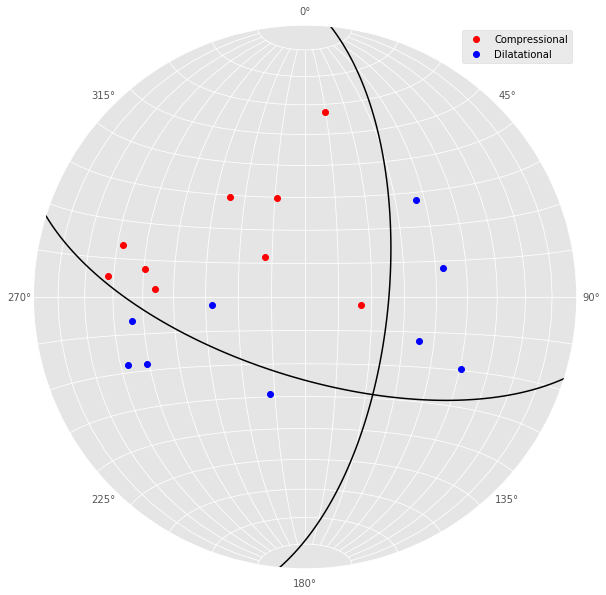

In [60]:
fig = plot_polarities(event_located)

## Amplitude ratios

A simple extension of the first motion method is to take advantage of the difference in P and S-wave radiation patterns:

<img alt="Stein and Wysession Fig 4.2-7" align="centre" style="width:20%" src="http://levee.wustl.edu/seismology/book/chapter4/chap4_sr/4_2_07_s.jpg">

By taking the ratio of P and S wave amplitudes we can estimate where on the focal sphere we are. This provides additional information
to better constrain the focal mechanism, and can be especially useful near the nodal planes, where S amplitude is maximized but first
motion polarities of P waves can be hard to pick. We won't make use of this in your assignment, but you should read Stein and Wysession 4.2.3.

Focal mechanisms can also be estimated by modelling body or/and surface waves, see Stein and Wysession 4.3.

## Moment tensor inversion

So far we have just considered the information relating to simple slip on a single fault, however, natural events are often more complicated. At relatively low sampling
frequencies and large station-reciever distances, the high frequencies that show this complexity are lost, however, for larger events the complexity is manifest at
lower frequencies, meaning that we can resolve some of these complexities using seismic data. One way to resolve some of the complexity is to compute moment tensors.

Read Stein and Wysession 4.4 on moment tensors.  For some information on how moment tensors are routinely computed for earthquakes in New Zealand,
read [Ristau 2008](https://pubs.geoscienceworld.org/ssa/srl/article/79/3/400/367690/implementation-of-routine-regional-moment-tensor).  The
moment tensors are available via the [GeoNet github page](https://github.com/GeoNet/data/tree/master/moment-tensor). You should select some
moment tensors from the GeoNet dataset to answer the "Slip Parameters" question in the assignment.